In [1]:
import unicodedata
import lxml.html
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import time
import os
import math
import json
import time
import datetime
from plotly import graph_objects as go
import plotly.express as px
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer 
le = preprocessing.LabelEncoder()
now = datetime.datetime.now()

#### Load standings data

In [2]:
st = pd.read_csv('C:\\Users\\pddnh\\Documents\\GitHub\\baseball\\Standings.csv')
st['G'] = st['W']+st['L']+st['T']
st.G.describe()

count    520.000000
mean      14.176923
std        3.266495
min        2.000000
25%       12.000000
50%       15.000000
75%       16.000000
max       20.000000
Name: G, dtype: float64

In [3]:
def add_lg_avg_RF_RA(z):
    z = z.merge(z.groupby(['Org', 'League', 'Year'])['RF'].mean().reset_index(name='lgRF'),on=['Org', 'League', 'Year'], how='inner')
    z = z.merge(z.groupby(['Org', 'League', 'Year'])['RA'].mean().reset_index(name='lgRA'),on=['Org', 'League', 'Year'], how='inner')
    z = z.merge(z.groupby(['Org', 'League', 'Year'])['G'].mean().reset_index(name='lgG'), on=['Org', 'League', 'Year'], how='inner')
    z['RF+'] = round(z['RF'] / z['lgRF'] * 100, 1)
    z['RA+'] = round(z['RA'] / z['lgRA'] * 100, 1)
    return z
st = add_lg_avg_RF_RA(st)
st = st[(st['lgG']>9) & (st['G']>8) & (st['RF']>0) & (st['RA']>0)]

In [4]:
# Remove outliers
st = st[~st['Year'].isin([2007, 2008])]
st = st[~((st['League']=='Caspian') & (st['Year']==2010))]
st = st[~((st['Team']=='Athletics') & (st['Year']==2010))]
st = st[~((st['Team']=='Athletics') & (st['Year']==2011))]

In [5]:
X = st.iloc[:,21:23]
y = st.iloc[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [7]:
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
st['xPct'] = reg.predict(st[['RF+', 'RA+']])
x1_range = np.linspace(st['RF+'].min(), st['RF+'].max(), 200)
#x2_range = np.linspace(st.min(), st['RA+'].max(), 100)
y_range = []
for i in range(310):
    y_range.append(reg.coef_[0]*i + reg.coef_[1]*i + reg.intercept_)

0.8283750773117989
[ 0.00344118 -0.00309706]
0.472705250718421


In [8]:
dt = DecisionTreeRegressor(max_depth=10, random_state=0).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(dt.score(X, y))
print(dt.feature_importances_)
st['xPct_DT'] = dt.predict(st[['RF+', 'RA+']])

0.9459356570796466
[0.17676448 0.82323552]


In [9]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(10)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
st['xPct_KNN'] = knn.predict(st[['RF+', 'RA+']])
knn.score(X, y)

0.8784362869486161

In [10]:
h = 95
p = 275
print('Reg:',reg.predict([[h, p]])[0])
print('KNN:',knn.predict([[h,p]])[0])
print('DT:',dt.predict([[h, p]])[0])

Reg: -0.05207403463097465
KNN: 0.040499999999999994
DT: 0.5


In [11]:
st[(st['RF+'].between(95, 105)) & (st['RA+'].between(95,105))].agg({'W':'sum', 'G':'sum'})

W    131
G    216
dtype: int64

In [12]:
131/216

0.6064814814814815

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    #x=tms['wRC+'],
    #y=tms['RA+'],
    x=st['RF+'],
    y=st['RA+'],
    mode='markers',
    marker=dict(color=st['xPct']*25),
    text=st['League']+' '+st['Team']+' '+st['Year'].astype(str)+'<br>'+st['Pct'].astype(str)+'<br>xPct: '+round(st['xPct'],3).astype(str)+'<br>RF+:'+st['RF+'].astype(str)+'<br>RA+: '+st['RA+'].astype(str)+'<br>'+st['Postseason'].astype(str)
))
fig.update_layout(
    title='Relationship Between a Team\'s Hitting and Pitching on Win Percentage',
    xaxis_title='RF+',
    yaxis_title='RA-',
    template = 'plotly_white'
)
fig.show()

In [17]:
import matplotlib.pyplot as plt
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



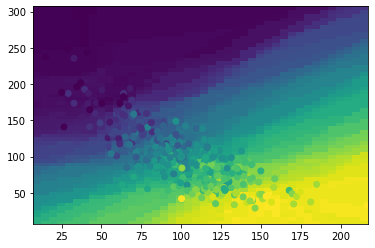

In [18]:
a = np.arange(min(st['RF+'].append(st['RA+']))-5, max(st['RF+'])+5, 5)
b = np.arange(min(st['RF+'].append(st['RA+']))-5, max(st['RF+'].append(st['RA+']))+5, 5)
aa, bb = np.meshgrid(a,b)
Z = np.zeros(aa.shape)
AA = pd.DataFrame(aa)
BB = pd.DataFrame(bb)
for i in range(aa.shape[0]):
    for j in range(aa.shape[1]):
        Z[i, j] = knn.predict([[AA.iloc[i,j], BB.iloc[i,j]]])[0]
plt.pcolor(aa, bb, Z)
plt.scatter(st['RF+'], st['RA+'], c=st['Pct'])
plt.show()

In [19]:
color_scale = [[0, 'red'], [0.5, 'white'], [1, 'blue']]

fig = go.Figure(data =
    go.Contour(
        z=Z,
        x=aa[0],
        y=aa[0],
        #colorscale='Hot',
        colorscale=color_scale,
        contours=dict(
            coloring ='heatmap',
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 12,
                color = 'black',
            )
    )))
fig.add_trace(go.Scatter(
    #x=tms['wRC+'],
    #y=tms['RA+'],
    x=st['RF+'],
    y=st['RA+'],
    mode='markers',
    marker=dict(color=st['Pct']),
    text=st['League']+' '+st['Team']+' '+st['Year'].astype(str)+'<br>'+st['Pct'].astype(str)+'<br>xPct: '+round(st['xPct_KNN'],3).astype(str)+'<br>RF+:'+st['RF+'].astype(str)+'<br>RA+: '+st['RA+'].astype(str)+'<br>'+st['Postseason'].astype(str)
))
fig.add_hline(y=100, line_width=3, line_dash="dash", line_color="white")
fig.add_vline(x=100, line_width=3, line_dash="dash", line_color="white")
fig.update_layout(
    title='Expected Winning % for a Team Based on Runs Scored and Runs Allowed',
    xaxis_title='RF+',
    yaxis_title='RA+',
    template = 'plotly_white',
)
fig.show()
#fig.write_html('xPct.html', include_plotlyjs='cdn')

In [20]:
st['residual_reg'] = st['xPct'] - st['Pct']
st['residual_knn'] = st['xPct_KNN'] - st['Pct']
st['residual_dt'] = st['xPct_DT'] - st['Pct']

fig = px.scatter(
    st, 
    x='xPct_KNN', y='residual_knn',
    marginal_y='violin',
    color='Pct', trendline='ols'
)
fig.update_layout(
    title='Residual Plot of Model Predictions',
    xaxis_title='Predicted',
    yaxis_title='Residual',
    template = 'plotly_white',
)
fig.show()

In [21]:
fig = px.scatter(st, x='RF+', y='RA+', color='Pct', size='Pct', trendline='ols')
fig.update_layout(
    xaxis_title='RF+',
    yaxis_title='RA+',
    template = 'plotly_white',
)
fig.show()

In [22]:
fig = px.scatter(st, x='RF+', y='Pct', color='Pct', size='Pct', trendline='ols')
fig.update_layout(
    xaxis_title='RF+',
    yaxis_title='Pct',
    template = 'plotly_white',
)
fig.show()

In [23]:
fig = px.scatter(st, x='RA+', y='Pct', color='Pct', size='Pct', trendline='ols')
fig.update_layout(
    xaxis_title='RA-',
    yaxis_title='Pct',
    template = 'plotly_white',
)
fig.show()

In [49]:
st['id'] = st['Org']+st['League']+st['Year'].astype(str)+st['Team']

In [51]:
ndf = st.merge(ndf, on='id', how='inner')
ndf = ndf.sort_values('PA', ascending=False)
for tm in ndf.id.unique():
    ndf.loc[ndf[ndf['id']==tm]['PA'][:9].index, 'Core'] = True
    ndf.loc[ndf[ndf['id']==tm]['PA'][9:].index, 'Core'] = False

ndf = ndf[ndf['Core']==True]

In [73]:
ndf.groupby('id')['wRAAc'].sum().sort_values()

id
MABL18+2015Los Pericos      -46.30
MABL45+2017Brewers          -38.69
RRLSouthern2015Farmington   -34.84
RRLSouthern2017Ashippun     -33.05
MABL35+2017White Sox        -32.58
                             ...  
RRLSouthern2016Rockers       46.03
MABL18+2015Monarchs          46.45
MABL35+2017Athletics         48.36
RRLSouthern2017Neosho        50.45
RRLSouthern2014Neosho        56.22
Name: wRAAc, Length: 239, dtype: float64

In [108]:
#import seaborn as sns
#sns.boxplot(x='id', y='wRAAc', data=ndf[(ndf['Year_x']==2016) & (ndf['League_x']=='Southern')])
fig = px.box(ndf[(ndf['Year_x']==2017) & (ndf['League_x']=='Southern')], y='Team_x', x='wRAAc', points='all')
fig.show()

In [109]:
ndf[(ndf['League_x']=='Southern') & (ndf['Year_x']==2017)].groupby('id')['wRAAc'].sum().sort_values()

id
RRLSouthern2017Ashippun        -33.05
RRLSouthern2017Farmington      -29.20
RRLSouthern2017Watertown       -11.60
RRLSouthern2017Juneau            1.54
RRLSouthern2017Lebanon           2.13
RRLSouthern2017Janesville        6.21
RRLSouthern2017Johnson Creek    10.70
RRLSouthern2017Milton           13.90
RRLSouthern2017Clyman           15.44
RRLSouthern2017Rockers          20.29
RRLSouthern2017Neosho           50.45
Name: wRAAc, dtype: float64

In [119]:
ndf.query('wRAAc>0').groupby('id')['wRAAc'].count().reset_index(name='Over_0').set_index('id')

,Over_0
id,
MABL17+2017Blue Sox,1
MABL17+2017Buckinghams,3
MABL17+2017Buschmen,5
MABL17+2017Epic,5
MABL18+2012Angels,5
...,...
RRLSouthern2017Neosho,7
RRLSouthern2017Rockers,5
RRLSouthern2017Watertown,3


In [123]:
ndf = ndf.merge(ndf.query('wRAAc>0').groupby('id')['wRAAc'].count().reset_index(name='>0').set_index('id'), on='id', how='left')
ndf = ndf.merge(ndf.query('wRAAc>1').groupby('id')['wRAAc'].count().reset_index(name='>1').set_index('id'), on='id', how='left')
ndf = ndf.merge(ndf.query('wRAAc>2').groupby('id')['wRAAc'].count().reset_index(name='>2').set_index('id'), on='id', how='left')
ndf = ndf.merge(ndf.query('wRAAc>3').groupby('id')['wRAAc'].count().reset_index(name='>3').set_index('id'), on='id', how='left')
ndf = ndf.merge(ndf.query('wRAAc>4').groupby('id')['wRAAc'].count().reset_index(name='>4').set_index('id'), on='id', how='left')

In [134]:
ndf.groupby('>4').agg({'W':'sum', 'L':'sum', 'G':'sum'})

,W,L,G
>4,,,
1.0,4971,5413,10420
2.0,5076,3051,8145
3.0,2295,1323,3618
4.0,1773,774,2556
5.0,747,198,954
6.0,387,45,432


In [137]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ndf['>0'],
    y=ndf['W']/ndf['G'],
    mode='markers',
    text=ndf['id']
    
))
fig.show()
fig = px.box(ndf, x='>0', y='Pct')
fig.show()

In [151]:
st['bin'] = pd.qcut(st['RF+'], 5, labels=['Very Bad', 'Bad', 'Average', 'Good', 'Very Good'])
ndf = ndf.merge(st[['id', 'bin']], on='id', how='inner')

In [195]:
ndf.groupby('bin')['>0'].mean()

bin
Very Bad     2.095491
Bad          3.925558
Average      4.666667
Good         5.466667
Very Good    6.207547
Name: >0, dtype: float64

In [194]:
ndf[ndf['id']=='RRLSouthern2014Milton'][['Last', 'wRC']]

,Last,wRC
171,Klawitter,13.5
172,Shere,20.2
173,Sagitis,11.3
174,Steinke,8.3
175,Shere,16.7
176,Jacobson,9.6
177,Allison,6.4
178,Catacutan,9.0
179,Siriani,7.5


In [191]:
ndf.wRAAc.describe()

count    2148.000000
mean        0.505810
std         4.120853
min       -10.290000
25%        -2.310000
50%         0.040000
75%         2.992500
max        18.950000
Name: wRAAc, dtype: float64

In [192]:
ndf

,TeamID,Org_x,League_x,Year_x,Team_x,W,L,T,Pct,GB,RF,RA,Pyth,xWin,W_added,Season,Postseason,G,lgRF,lgRA,lgG,RF+,RA+,xPct,xPct_DT,xPct_KNN,residual_reg,residual_knn,residual_dt,id,PID,First,Last,Org_y,League_y,Team_y,Year_y,GP,GS,PA,AB,R,H,1B,2B,3B,HR,RBI,BB,K,HBP,SB,CS,SH,SF,TB,BA,OBP,SLG,OPS,opsPlus,wRAA,wOBA,wRC,wRCPlus,All-Star,DP,ROE,FC,LOB,Outs,lgR,lgPA,BA_lg,OBP_lg,SLG_lg,OPS_lg,wOBA_lg,wOBAscale,OPS+,wRAAc,wRC+,Core,>0,>1,>2,>3,>4,bin
0,NaN,RRL,Northern,2014,Rubicon,13,5,0,0.722,2.0,143.0,62.0,0.841765118,15.2,-2.2,0,0.0,18,108.900000,108.900000,18.1,131.3,56.9,0.748309,0.722,0.7565,0.026309,0.0345,0.0,RRLNorthern2014Rubicon,737,Drew,Giesen,RRL,Northern,Rubicon,2014,18,18,95,78,24,28.0,21.0,4.0,1,2,20,13,9.0,0,3,0,3.0,1.0,40,0.359,0.446,0.513,0.959,171.0,8.55,0.416,22.1,156.0,0.0,NaN,NaN,NaN,NaN,NaN,5.180952,34.766667,0.281,0.365,0.355,0.720,0.321,1.137072,167.0,7.94,156,True,8.0,5.0,5.0,5.0,3.0,Very Good
1,NaN,RRL,Northern,2014,Rubicon,13,5,0,0.722,2.0,143.0,62.0,0.841765118,15.2,-2.2,0,0.0,18,108.900000,108.900000,18.1,131.3,56.9,0.748309,0.722,0.7565,0.026309,0.0345,0.0,RRLNorthern2014Rubicon,1999,Chris,Rowoldt,RRL,Northern,Rubicon,2014,18,18,87,76,16,23.0,20.0,3.0,0,0,15,8,4.0,1,2,0,2.0,0.0,26,0.303,0.376,0.342,0.718,103.0,0.69,0.326,13.3,101.0,0.0,NaN,NaN,NaN,NaN,NaN,5.180952,34.766667,0.281,0.365,0.355,0.720,0.321,1.137072,99.0,0.38,103,True,8.0,5.0,5.0,5.0,3.0,Very Good
2,NaN,RRL,Northern,2014,Rubicon,13,5,0,0.722,2.0,143.0,62.0,0.841765118,15.2,-2.2,0,0.0,18,108.900000,108.900000,18.1,131.3,56.9,0.748309,0.722,0.7565,0.026309,0.0345,0.0,RRLNorthern2014Rubicon,1739,Derek,Pankow,RRL,Northern,Rubicon,2014,17,17,83,64,15,18.0,12.0,5.0,0,1,16,13,8.0,3,2,0,1.0,2.0,26,0.281,0.415,0.406,0.821,132.0,3.82,0.367,15.7,126.0,0.0,NaN,NaN,NaN,NaN,NaN,5.180952,34.766667,0.281,0.365,0.355,0.720,0.321,1.137072,128.0,3.36,127,True,8.0,5.0,5.0,5.0,3.0,Very Good
3,NaN,RRL,Northern,2014,Rubicon,13,5,0,0.722,2.0,143.0,62.0,0.841765118,15.2,-2.2,0,0.0,18,108.900000,108.900000,18.1,131.3,56.9,0.748309,0.722,0.7565,0.026309,0.0345,0.0,RRLNorthern2014Rubicon,1692,Shane,O'Hagan,RRL,Northern,Rubicon,2014,17,17,78,67,17,23.0,16.0,5.0,0,2,14,7,12.0,1,1,0,1.0,2.0,34,0.343,0.403,0.507,0.910,158.0,4.98,0.391,16.4,138.0,0.0,NaN,NaN,NaN,NaN,NaN,5.180952,34.766667,0.281,0.365,0.355,0.720,0.321,1.137072,153.0,4.80,141,True,8.0,5.0,5.0,5.0,3.0,Very Good
4,NaN,RRL,Northern,2014,Rubicon,13,5,0,0.722,2.0,143.0,62.0,0.841765118,15.2,-2.2,0,0.0,18,108.900000,108.900000,18.1,131.3,56.9,0.748309,0.722,0.7565,0.026309,0.0345,0.0,RRLNorthern2014Rubicon,1220,Kam,Koplitz,RRL,Northern,Rubicon,2014,17,17,73,67,13,24.0,20.0,3.0,0,1,13,3,6.0,2,0,0,1.0,0.0,30,0.358,0.403,0.448,0.851,141.0,3.76,0.375,14.3,130.0,0.0,NaN,NaN,NaN,NaN,NaN,5.180952,34.766667,0.281,0.365,0.355,0.720,0.321,1.137072,137.0,3.47,132,True,8.0,5.0,5.0,5.0,3.0,Very Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,NaN,MABL,18+,2013,Bulldogs,4,11,0,0.267,8.0,76.0,130.0,0.254718645,3.8,0.2,0,0.0,15,92.833333,92.833333,15.0,81.9,140.0,0.320950,0.267,0.2392,0.053950,-0.0278,0.0,MABL18+2013Bulldogs,1502,Chris,McGill,MABL,18+,Bulldogs,2013,2,0,10,9,1,3.0,2.0,1.0,0,0,1,0,0.0,0,2,0,0.0,1.0,4,0.333,0.300,0.444,0.744,120.0,NaN,0.302,1.5,NaN,NaN,0.0,0.0,0.0,0.0,NaN,6.247191,39.359551,0.271,0.359,0.324,0.683,0.308,1.165584,121.0,-0.05,97,True,4.0,1.0,1.0,NaN,NaN,Bad
2144,NaN,MABL,18+,2013,Bulldogs,4,11,0,0.267,8.0,76.0,130.0,0.254718645,3.8,0.2,0,0.0,15,92.833333,92.833333,15.0,81.9,140.0,0.320950,0.267,0.2392,0.053950,-0.0278,0.0,MABL18+2013Bulldogs,1719,Jake,Osburn,MABL,18+,Bulldogs,2013,2,0,7,5,4,2.0,2.0,0.0,0,0,1,2,0.0,0,4,0,0.0,0.0,2,0.400,0.571,0.400,0.971,182.0,NaN,0.450,2.0,NaN,NaN,0.0,

In [188]:
ndf.query('bin=="Very Good"').groupby('id')['>4'].mean()

id
MABL18+2012Athletics          1.0
MABL18+2013Reds               2.0
MABL18+2014Athletics          4.0
MABL18+2015Angels             2.0
MABL18+2015Monarchs           5.0
MABL18+2016Athletics          1.0
MABL18+2017Athletics          3.0
MABL18+2017Monarchs           1.0
MABL18+2018Angels             2.0
MABL18+2018Athletics          2.0
MABL18+2018Los Banditos       2.0
MABL18+2019Los Banditos       NaN
MABL18+2021Angels             2.0
MABL18+2021Athletics          3.0
MABL18+2021Los Banditos       2.0
MABL35+2012Athletics          1.0
MABL35+2016Athletics          1.0
MABL35+2016Monarchs           5.0
MABL35+2016Pirates            2.0
MABL35+2017Athletics          6.0
MABL35+2017Monarchs           1.0
MABL35+2018Athletics          2.0
MABL35+2018Monarchs           1.0
MABL35+2019Monarchs           3.0
MABL45+2017Grays              4.0
MABL45+2017Sand Crabs         5.0
MABL45+2018Sand Crabs         4.0
MABL55+2018Reds               3.0
RRLNorthern2012Hustisford     4.0
RRLNorthern

In [181]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ndf.query('bin=="Very Good"').groupby('id')['>4'].mean(),
    y=9-ndf.query('bin=="Very Good"').groupby('id')['>4'].mean(),
    mode='markers',
    text=ndf['id']
    
))
fig.show()

In [24]:
def add_rate_stats(z):
    """
    input: df with general hitting data
    output: calculates rate stats and attaches to the df
    """
    z['BA'] = round(z['H']/z['AB'],3)
    z['OBP'] = round((z['H']+z['BB']+z['HBP'])/(z['AB']+z['BB']+z['HBP']+z['SF']),3)
    z['SLG'] = round(z['TB']/z['AB'],3)
    z['OPS'] = round(z['SLG'] + z['OBP'],3)
    return z

def add_runs_created(z):
    z['RC'] = round(((((2.4*(z['AB']+z['BB']+z['HBP']+z['SH']+z['SF']))+(z['H']+z['BB']-z['CS']+z['HBP']))*((3*(z['AB']+z['BB']+z['HBP']+z['SH']+z['SF']))+((1.25*(z['H']-z['2B']-z['3B']-z['HR']))+(1.69*z['2B'])+(3.02*z['3B'])+(3.73*z['HR'])+(.29*(z['BB']+z['HBP']))+(.492*(z['SH']+z['SF']+z['SB']))-(.4*z['K']))))/(9*(z['AB']+z['BB']+z['HBP']+z['SH']+z['SF'])))-(.9*(z['AB']+z['BB']+z['HBP']+z['SH']+z['SF'])),2)
    return z

def add_lg_woba(z):
    z['wOBA'] = round(((0.691*z['BB']) + (0.722*z['HBP']) + (0.884*z['1B']) + (1.257*z['2B']) + (1.593*z['3B']) + (2.058*z['HR'])) / (z['AB'] + z['BB'] + z['HBP'] + z['SF']),3)
    return z

def make_lg_avg(z):
    stats = ['GP', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'RBI', 'BB', 'K', 'HBP', 'SB', 'CS', 'SF', 'SH', 'TB']
    #lgR = z.groupby(['Org', 'League', 'Year'])['R'].sum().reset_index(name='lgR')['lgR']
    #lgPA = z.groupby(['Org', 'League', 'Year'])['PA'].sum().reset_index(name='lgPA')['lgPA']
    z = z.groupby(['Org', 'League', 'Year']).agg({'GP':'mean', 'PA':'mean', 'AB':'mean', 'R':'mean', 'H':'mean', '1B':'mean', '2B':'mean', '3B':'mean', 'HR':'mean', 'RBI':'mean', 'BB':'mean', 'K':'mean', 'HBP':'mean', 'SB':'mean', 'CS':'mean', 'SF':'mean', 'SH':'mean', 'TB':'mean'}).reset_index()
    z['lgR'] = z.groupby(['Org', 'League', 'Year'])['R'].sum().reset_index(name='lgR')['lgR']
    z['lgPA'] = z.groupby(['Org', 'League', 'Year'])['PA'].sum().reset_index(name='lgPA')['lgPA']
    #z = z.merge(lgR, on=[['Org', 'League', 'Year']], how='inner')
    for i in stats:
        z[i] = round(z[i],1)
    add_rate_stats(z)
    add_lg_woba(z)
    z['wOBAscale'] = z['OBP']/z['wOBA']
    return z

def add_ops_plus(z, avg):
    #(OBP / lgOBP + SLG / lgSLG - 1) * 100
    z = z.merge(avg[['Org', 'League', 'Year', 'lgR', 'lgPA', 'BA', 'OBP', 'SLG', 'OPS', 'wOBA', 'wOBAscale']], on=['Org', 'League', 'Year'], suffixes=['', '_lg'], how='inner')
    z['OPS+'] = round((z['OBP']/z['OBP_lg'] + z['SLG']/z['SLG_lg'] -1)*100,0)
    return z

def add_woba(z):
    #(0.691×uBB + 0.722×HBP + 0.884×1B + 1.257×2B + 1.593×3B + 2.058×HR) / (AB + BB – IBB + SF + HBP)
    z['wOBA'] = round(((0.691*z['BB']) + (0.722*z['HBP']) + (0.884*z['1B']) + (1.257*z['2B']) + (1.593*z['3B']) + (2.058*z['HR'])) / (z['AB'] + z['BB'] + z['HBP'] + z['SF']),3)
    return z

def add_wRAA(z, avg):
    #wRAA formula = ((wOBA-lgwOBA)/wOBAScale)*PA;
    #z = z.merge(avg[['Org', 'League', 'Year', 'wOBA', 'wOBAscale']], on=['Org', 'League', 'Year'], suffixes=['', '_lg'], how='outer')
    z['wRAAc'] = round(((z['wOBA'] - z['wOBA_lg']) / z['wOBAscale'])*z['PA'],2)
    return z

def add_wRC(z, avg):
    #wRC = (((wOBA-League wOBA)/wOBA Scale)+(League R/PA))*PA
    #z = z.merge(avg[['Org', 'League', 'Year', 'wOBA']], on=['Org', 'League', 'Year'], suffixes=['', '_lg'], how='outer')
    z['wRC'] = round((((z['wOBA'] - z['wOBA_lg']) / z['wOBAscale']) + (z['lgR'] / z['lgPA'])) * z['PA'],1)
    return z

def add_wRC_plus(z, avg):
    #wRC+ = (((wRAA/PA + League R/PA) + (League R/PA – Park Factor* League R/PA))/ (AL or NL wRC/PA excluding pitchers))*100
    z['wRC+'] = round(((z['wRAAc']/z['PA'] + z['lgR']/z['lgPA'])  / (z['lgR']/z['lgPA'])) * 100, 0)
    return z

In [25]:
import math
#16, 14, 9
#82,55,62
2*(math.sqrt(55)-math.sqrt(62))

-0.9156187738322963

In [26]:
df = pd.read_csv('C:\\Users\\pddnh\\Documents\\GitHub\\baseball\\Master_Hitting.csv')
df = add_rate_stats(df)
df['OBP'].fillna(0, inplace=True)
df['SLG'].fillna(0, inplace=True)
df['OPS'].fillna(0, inplace=True)
df = add_woba(df)
h_lg_avg = make_lg_avg(df)
df = add_ops_plus(df, h_lg_avg)
df = add_wRAA(df, h_lg_avg)
df = add_wRC(df, h_lg_avg)
df = add_wRC_plus(df, h_lg_avg)
df['wRC+'].fillna(0, inplace=True)
df['wRC+'] = df['wRC+'].astype(int)
df = df[df['Org'].isin(['RRL', 'MABL'])]

In [27]:
df.query('Org=="MABL" & League=="35+" & Year==2017')['PA']

4871    45
4872    29
4873    30
4874    28
4875    47
        ..
4963    25
4964    48
4965    56
4966    36
4967    26
Name: PA, Length: 97, dtype: int64

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df.query('Org=="MABL" & League=="35+" & Year==2017')['wOBA'],
    y=df.query('Org=="MABL" & League=="35+" & Year==2017')['PA'],
    text=df.query('Org=="MABL" & League=="35+" & Year==2017')['Last'],
    mode='markers',
    name='League'
))
fig.add_trace(go.Scatter(
    x=df.query('Org=="MABL" & League=="35+" & Year==2017 & Team=="Athletics"')['wOBA'],
    y=df.query('Org=="MABL" & League=="35+" & Year==2017 & Team=="Athletics"')['PA'],
    text=df.query('Org=="MABL" & League=="35+" & Year==2017 & Team=="Athletics"')['Last'],
    mode='markers',
    name='Team'
))

fig.show()

In [32]:
ndf = df.merge(st[['Org', 'League', 'Year', 'Team']], on=['Org', 'League', 'Year', 'Team'], how='inner')

In [44]:
ndf['id'] = ndf['Org']+ndf['League']+ndf['Year'].astype(str)+ndf['Team']

In [47]:
ndf.groupby('id').agg(lambda x: x.value_counts().index[8])

IndexError: index 8 is out of bounds for axis 0 with size 7

In [290]:
tms = df.query('Year!=2020').groupby(['Org', 'League', 'Team', 'Year']).agg({'PA':'sum', 'AB':'sum', 'H':'sum', 'SF':'sum', 'BB':'sum', 'HBP':'sum', '1B':'sum', '2B':'sum', '3B':'sum', 'HR':'sum', 'TB':'sum', 'CS':'sum', 'GP':'sum', 'K':'sum', 'R':'sum', 'RBI':'sum', 'SB':'sum', 'SH':'sum'}).reset_index()
tms = add_rate_stats(tms)
tms['OBP'].fillna(0, inplace=True)
tms['SLG'].fillna(0, inplace=True)
tms['OPS'].fillna(0, inplace=True)
tms = add_woba(tms)
h_lg_avg = make_lg_avg(tms)
tms = add_ops_plus(tms, h_lg_avg)
tms = add_wRAA(tms, h_lg_avg)
tms = add_wRC(tms, h_lg_avg)
tms = add_wRC_plus(tms, h_lg_avg)
tms['wRC+'].fillna(0, inplace=True)
tms['wRC+'] = tms['wRC+'].astype(int)

tms = tms[tms['Org'].isin(['RRL', 'MABL']) & (tms['League'].isin(['18+', '35+', 'Southern', 'Northern'])) & (tms['PA']>=350)]
tms = tms.merge(st[['Org', 'League', 'Team', 'Year', 'Pct', 'RF', 'RA', 'Postseason']], on=['Org', 'League', 'Team', 'Year'], how='inner')

In [291]:
df2 = pd.read_csv('C:\\Users\\pddnh\\Documents\\GitHub\\baseball\\Master_Pitching.csv')
df2 = df2.groupby(['Org', 'League', 'Team', 'Year']).agg({'IP':'sum', 'Outs':'sum', 'R':'sum'}).reset_index()
df2 = df2[df2['Org'].isin(['RRL', 'MABL']) & (df2['League'].isin(['18+', '35+', 'Southern', 'Northern'])) & (df2['Year']<2019) & (df2['IP']>=50)]
df2['R/A'] = df2['R']/df2['IP']*9

In [292]:
p_lg_avg = df2.groupby(['Org', 'League', 'Year']).agg({'R':'sum', 'IP':'sum'}).reset_index()
p_lg_avg['R/A'] = p_lg_avg['R']/p_lg_avg['IP']*9

In [293]:
df2 = df2.merge(p_lg_avg[['Org', 'League', 'Year', 'R/A']], on=['Org', 'League', 'Year'], suffixes=['','_lg'], how='inner')
df2['RA+'] = round(df2['R/A_lg']/df2['R/A']*100,1)

In [294]:
tms.drop(tms.query('Team=="Athletics" & Year<2012').index.tolist(), inplace=True)

In [295]:
tms = tms.merge(df2[['Org', 'League', 'Team', 'Year', 'RA+']], on=['Org', 'League', 'Team','Year'], how='inner')
tms['RA_log'] = np.log(tms['RA+'])
tms['RC_log'] = np.log(tms['wRC+'])
tms.drop(tms.index[51:53], inplace=True)

In [296]:
tms_reg = tms[['Org', 'League', 'Team', 'Year', 'RA+', 'RA_log', 'RC_log', 'wRC+', 'Pct', 'Postseason']]
tms_reg

,Org,League,Team,Year,RA+,RA_log,RC_log,wRC+,Pct,Postseason
0,MABL,18+,Athletics,2012,122.6,4.808927,4.615121,101,0.625,0.0
1,MABL,18+,Black Sox,2012,108.3,4.684905,4.682131,108,0.688,1.0
2,MABL,18+,Braves,2012,94.5,4.548600,4.465908,87,0.688,0.0
3,MABL,18+,Bulldogs,2012,107.5,4.677491,4.718499,112,0.500,0.0
4,MABL,18+,Diablos,2012,73.7,4.300003,4.499810,90,0.375,0.0
...,...,...,...,...,...,...,...,...,...,...
175,RRL,Southern,Johnson Creek,2015,95.4,4.558079,4.644391,104,0.500,0.0
176,RRL,Southern,Milton,2015,211.7,5.355170,4.595120,99,0.778,0.0
177,RRL,Southern,Neosho,2015,210.9,5.351384,4.905275,135,0.833,0.0
178,RRL,Southern,Rockers,2015,175.5,5.167639,4.762174,117,0.611,0.0


In [ ]:
X = tms_reg.iloc[:,5:7]
y = tms_reg.iloc[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [ ]:
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
f'Linear Regression: RA+ is {round(reg.coef_[0]/reg.coef_[1],3)} times more important than wRC+'

In [ ]:
dt = DecisionTreeRegressor(max_depth=10, random_state=0).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(dt.score(X, y))
print(dt.feature_importances_)
f'Dec Tree Regression: wRC+ is {round(dt.feature_importances_[1]/dt.feature_importances_[0],1)} times more important than RA+'

In [ ]:
p = 95
h = 110
p_log = np.log(p)
h_log = np.log(h)
print('DT:',dt.predict([[p_log, h_log]])[0])
print('Lin Reg:',reg.predict([[p_log, h_log]])[0])

In [ ]:
from plotly.offline import iplot
posX = np.arange(75, 125, 1)
posY = np.arange(75, 125, 1)
posXX, posYY = np.meshgrid(posX, posY)
colours = ['blue', 'orange', 'green', 'red', 'purple']

layout = {'title': 'Point Grid'}
traces = []

for x, y, c in zip(posXX.T, posYY.T, colours):
    traces.append({'x': x,
                   'y': y,
                   'mode': 'markers',
                   'marker': {'color': c,
                              'size': 10
                             },
                   #'text':(reg.predict([[np.log(x), np.log(y)]])[0]*20).astype(str),
                   'name': c})

layout['xaxis'] = {'title': 'X Position'}
layout['yaxis'] = {'title': 'Y Position'}

iplot({'data': traces, 'layout': layout})

In [ ]:
posXX

In [ ]:
tms['xPct'] = reg.predict(tms_reg[['RA_log', 'RC_log']])
tms['xPct_DT'] = dt.predict(tms_reg[['RA+', 'wRC+']])
tms.sort_values('xPct')[['Team', 'Year', 'RA+', 'wRC+', 'Pct', 'xPct', 'xPct_DT', 'Postseason']].tail(15)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    #x=tms['wRC+'],
    #y=tms['RA+'],
    x=tms_reg['RC_log'],
    y=tms_reg['RA_log'],
    mode='markers',
    marker=dict(color=tms['Pct']*25),
    text=tms['League']+' '+tms['Team']+' '+tms['Year'].astype(str)+'<br>'+tms['Pct'].astype(str)+'<br>xPct: '+round(tms['xPct'],3).astype(str)+'<br>wRC+:'+tms['wRC+'].astype(str)+'<br>RA+: '+tms['RA+'].astype(str)+'<br>'+tms['Postseason'].astype(str)
))
fig.update_layout(
    title='Relationship Between Team Hitting and Pitching on Wins',
    xaxis_title='wRC+',
    yaxis_title='RA+',
    template = 'plotly_white'
)
fig.show()

In [ ]:
fig = px.scatter(tms, x='RA+', y='wRC+', color='Pct', size='Pct', trendline='ols')
fig.show()

In [ ]:
fig = px.scatter(tms, x='wRC+', y='Pct', color='Pct', size='Pct', trendline='ols')
fig.show()

In [ ]:
fig = px.scatter(tms, x='RA+', y='Pct', color='Pct', size='Pct', trendline='ols')
fig.show()

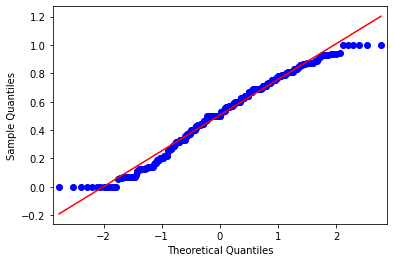

In [121]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
data = st['Pct']
qqplot(data, line='s')
pyplot.show()

In [122]:
from scipy.stats import shapiro
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.976, p=0.000
Sample does not look Gaussian (reject H0)


In [123]:
from scipy.stats import normaltest
# seed the random number generator
# generate univariate observations

# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=22.847, p=0.000
Sample does not look Gaussian (reject H0)


In [124]:
from scipy.stats import anderson
# seed the random number generator
# normality test
result = anderson(data)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 1.927
15.000: 0.570, data does not look normal (reject H0)
10.000: 0.649, data does not look normal (reject H0)
5.000: 0.778, data does not look normal (reject H0)
2.500: 0.908, data does not look normal (reject H0)
1.000: 1.080, data does not look normal (reject H0)


In [ ]:
z = np.polyfit(tms['RA+'], tms['wRC+'], 2)
f = np.poly1d(z)
x_new = np.linspace(0, 300, 50)
y_new = f(x_new)

In [ ]:
trace1 = go.Scatter(
                  x=tms['RA+'],
                  y=tms['wRC+'],
                  mode='markers',
                  marker=go.Marker(color='rgb(255, 127, 14)'),
                  text=tms['Team']+' '+tms['Year'].astype(str)+'<br>'+tms['Pct'].astype(str)+'<br>xPct: '+round(tms['xPct'],3).astype(str)+'<br>'+tms['Postseason'].astype(str),
                  name='Data'
                  )

trace2 = go.Scatter(
                  x=x_new,
                  y=y_new,
                  mode='lines',
                  marker=go.Marker(color='rgb(31, 119, 180)'),
                  name='Fit'
                  )
data = [trace1, trace2]
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='RA+', yaxis_title='wRC+')
fig.show()

In [ ]:
trace1 = go.Scatter(
                  x=tms['RA+'],
                  y=tms['wRC+'],
                  mode='markers',
                  marker=go.Marker(color='rgb(255, 127, 14)'),
                  name='Data'
                  )

trace2 = go.Scatter(
                  x=x_new,
                  y=y_new,
                  mode='lines',
                  marker=go.Marker(color='rgb(31, 119, 180)'),
                  name='Fit'
                  )
data = [trace1, trace2]
fig = go.Figure(data=data)
fig.update_layout(xaxis_title='RA+')
fig.show()

In [ ]:
tms['wRC+'].hist()

In [ ]:
df = pd.read_csv('C:\\Users\\pddnh\\Jupyter\\Fantasy.csv')
#df.drop(df.index[3011],inplace=True)
df = df[df['Keep']==1]
df['Name'] = df['Player'].apply(lambda x: x.split(' ')[1]+', '+x.split(' ')[0])

### Who had the best draft?

In [ ]:
df.query('Rank<5000').groupby('Draft_Team')['Rank'].mean().sort_values().plot(kind='bar')

In [ ]:
df.query('Rank<5000').groupby('Draft_Team')['Rank'].describe().sort_values('75%')

In [ ]:
df.query('Rank<5000').groupby('Draft_Team')['Rank'].describe().sort_values('75%')['75%'].plot(kind='bar')

In [ ]:
df[(df['Draft_Team']=='Lima Time!') & (df['Rank']<5000)].sort_values('Rank')[['Name','Pre_Rank','Rank', 'Diff']]

### Who drafted the most value?

In [ ]:
df.groupby('Draft_Team')['Diff'].describe().sort_values('25%', ascending=False)#['50%'].plot(kind='bar')

In [ ]:
df.groupby('Owner')['Salary'].describe()

In [ ]:
X = [df.iloc[:, 5].values]
y = [df.iloc[:, 7].values]

In [ ]:
df.columns

In [ ]:
X = np.asarray(df.iloc[:,5])
y = np.asarray(df.iloc[:,7])

In [ ]:
X.shape

In [ ]:
X = X.reshape(-1,1)
y = y.reshape(-1,1)

In [ ]:
#X = df.iloc[:,18]
#y = df.iloc[:,20]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [ ]:
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)

In [ ]:
reg.predict([[50]])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly.fit(X_poly, y)
lin2 = LinearRegression()
lin2.fit(X_poly,y)
#lin2_y_pred = lin2.predict(poly.fit_transform(X_test).reshape(1,-1))

In [ ]:
sns.scatterplot(x='Pre_Rank', y='Salary', data=df.query('Salary>0 & Pre_Rank<5000').sort_values('Salary', ascending=False))

In [ ]:
df.sort_values('Salary', ascending=False).head(20)#['Rank'].mean()